In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
#load data
walk1 = pd.read_csv('./data/walk1.csv')
walk2 = pd.read_csv('./data/walk2.csv')
run = pd.read_csv('./data/run.csv')
stairs = pd.read_csv('./data/stairs.csv')
relaxed = pd.read_csv('./data/relaxed.csv')


In [3]:
def clean_data(df, activity):
    '''
    This function cleans the data by:
    1. Drop columns with all missing values
    2. Convert datetime to date column and time column separately
    3. Drop the original datetime column
    4. Drop Time (s) column followed by dot and a number
    5. Create a new column for activity

    Parameters:
    df: pandas dataframe
    activity: string

    Returns:
    df: cleaned pandas dataframe 
    '''
    df = df.copy()
    # Drop columns with all missing values
    df.dropna(axis=1, how='all', inplace=True)
    # Convert datetime to date column and time column separately
    df['Date'] = pd.to_datetime(df['Actual System Time Text']).dt.date
    df['Time'] = pd.to_datetime(df['Actual System Time Text']).dt.time
    # Drop the original datetime column
    df.drop(columns=['Actual System Time Text', 'Actual System Time', 'Time (s)'], inplace=True)
    # Drop Time (s) column followed by dot and a number
    df = df[df.columns.drop(list(df.filter(regex='Time \(s\)\.\d+')))]
    # Create a new column for activity
    df['Activity'] = activity
    #if activity is walking, drop the Latitude (°)	Longitude (°)	Height (m)	Velocity (m/s)	Direction (°)	Horizontal Accuracy (m)	Vertical Accuracy (m) columns
    if activity == 'walking':
        df.drop(columns=['Latitude (°)', 'Longitude (°)', 'Height (m)', 'Velocity (m/s)', 'Direction (°)', 'Horizontal Accuracy (m)', 'Vertical Accuracy (m)'], inplace=True) 
    #if the activity is relaxed change the date to 2024-05-17
    if 'relaxed' in df['Activity'].values:
        new_start_time = pd.Timestamp('2024-05-17 15:34:25.868713140')

        # Combine Date and Time columns into a single datetime column
        df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

        # Filter the dataset based on the activity
        df_activity = df[df['Activity'] == activity].copy()

        # Adjust the times
        if not df_activity.empty:
            first_time = df_activity['DateTime'].iloc[0]
            df_activity['DateTime'] = new_start_time + (df_activity['DateTime'] - first_time)

            # Split DateTime back into Date and Time
            df_activity['Date'] = df_activity['DateTime'].dt.date
            df_activity['Time'] = df_activity['DateTime'].dt.time
            df_activity.drop(columns=['DateTime'], inplace=True)

        # Update the original dataframe with the adjusted times
        df.update(df_activity)
        
    return df

<>:26: SyntaxWarning: invalid escape sequence '\('
<>:26: SyntaxWarning: invalid escape sequence '\('
C:\Users\Lia\AppData\Local\Temp\ipykernel_39196\2111381136.py:26: SyntaxWarning: invalid escape sequence '\('
  df = df[df.columns.drop(list(df.filter(regex='Time \(s\)\.\d+')))]


In [4]:
walk1_df = clean_data(walk1,'walking')
walk2_df = clean_data(walk2,'walking')
run_df = clean_data(run,'running')
stairs_df = clean_data(stairs,'stairs')
relaxed_df = clean_data(relaxed,'relaxed')

In [5]:
#concatenate all dataframes and sort by date and time
df = pd.concat([walk1_df, walk2_df, run_df, stairs_df, relaxed_df])
#drop the DateTime column
df = df.drop(columns=['DateTime'])
df = df.sort_values(by=['Date', 'Time'])
#reset index
df = df.reset_index(drop=True)
#save the cleaned data to a csv file
df.to_csv('./data/all_data.csv', index=False)

In [6]:
all_data = pd.read_csv('./data/all_data.csv')
all_data.head()

,Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s),Illuminance (lx),Date,Time,Activity
0,-3.141193,2.638410,8.540117,-0.043371,0.065973,0.091019,48.0,2024-05-17,13:59:37.034873,walking
1,-3.337517,2.734178,8.322245,-0.043371,0.065973,0.091019,47.0,2024-05-17,13:59:37.045433,walking
2,-3.445256,2.743755,8.243237,-0.043371,0.065973,0.091019,46.0,2024-05-17,13:59:37.055443,walking
3,-3.545813,2.695871,8.339005,-0.043371,0.065973,0.091019,45.0,2024-05-17,13:59:37.065453,walking
4,-3.591303,2.657564,8.640674,-1.258382,0.047647,0.166155,44.0,2024-05-17,13:59:37.075432,walking


In [7]:
def add_heart_rate(df):
    '''
    Function that adds heart rate data to the dataframe given the activity type.

    Parameters:
    df: pandas dataframe

    Returns:
    df: pandas dataframe with heart rate data added 
    '''
    df = df.copy()
    
    
    # Extract only the minute part for resampling
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Minute'] = df['Timestamp'].dt.floor('min')

    # Generate heart rate data for each minute
    heart_rate_data = []
    for minute in df['Minute'].unique():
        activities_in_minute = df[df['Minute'] == minute]['Activity'].unique()
        for activity in activities_in_minute:
            if activity == 'walking':
                heart_rate = np.random.randint(80, 110)
            elif activity == 'running':
                heart_rate = np.random.randint(120, 150)
            elif activity == 'stairs':
                heart_rate = np.random.randint(100, 140)
            elif activity == 'relaxed':
                heart_rate = np.random.randint(60, 90)
            heart_rate_data.append({'Minute': minute, 'Activity': activity, 'Heart Rate (bpm)': heart_rate})

    # Create a DataFrame from the heart rate data
    heart_rate_df = pd.DataFrame(heart_rate_data)

    # Merge the heart rate data back into the original DataFrame
    df = pd.merge(df, heart_rate_df, on=['Minute', 'Activity'], how='left')

    # Set heart rate values to None except for the first record of each minute
    df['Heart Rate (bpm)'] = df.groupby('Minute')['Heart Rate (bpm)'].transform(lambda x: x.where(x.index == x.index[0], None))

    # Drop the Minute column
    df.drop(columns=['Minute'], inplace=True)
 
    return df

In [8]:
def aggregate(final_all_data):
    '''
    Function that aggregates the data by resampling the numerical columns to 100ms and the Activity column to mode.

    Parameters:
    final_all_data: pandas dataframe

    Returns:
    resampled_data: pandas dataframe with aggregated data
    '''
    final_all_data['Timestamp'] = pd.to_datetime(final_all_data['Date'] + ' ' + final_all_data['Time'])

    # Set the Timestamp as the index
    final_all_data.set_index('Timestamp', inplace=True)

    # Drop the original Date and Time columns as they are now redundant
    final_all_data.drop(columns=['Date', 'Time'], inplace=True)
    numerical_columns = final_all_data.select_dtypes(include=['float64', 'int64']).columns
    activity_column = 'Activity'

    # Resample numerical columns by taking the mean
    resampled_numerical = final_all_data[numerical_columns].resample('100ms').mean()

    # Resample the Activity column by taking the mode
    resampled_activity = final_all_data[activity_column].resample('100ms').apply(lambda x: x.mode()[0] if not x.mode().empty else None)

    # Combine the resampled numerical data and the Activity column
    resampled_data = pd.concat([resampled_numerical, resampled_activity], axis=1)

    # Drop rows with all missing values
    resampled_data.dropna(subset=['Acceleration x (m/s^2)', 'Acceleration y (m/s^2)', 'Acceleration z (m/s^2)'])

    # Save the resampled data to a new CSV file
    output_path = './data/aggregated_data.csv'
    resampled_data.to_csv(output_path)

In [9]:
data = pd.read_csv('./data/all_data.csv')
aggregate(data)

In [10]:
#Load the aggregated data
aggregated_data = pd.read_csv('./data/aggregated_data.csv')
final_data = add_heart_rate(aggregated_data)
#save the final data to a csv file
final_data.to_csv('./data/final_data.csv', index=False)
final_data.head()

,Timestamp,Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s),Illuminance (lx),Activity,Heart Rate (bpm)
0,2024-05-17 13:59:37.000,-3.420972,2.675691,8.604419,-0.272708,-0.055938,0.108734,45.571429,walking,99.0
1,2024-05-17 13:59:37.100,-2.785414,2.516785,9.533711,-0.050396,-0.243247,0.154549,54.500000,walking,NaN
2,2024-05-17 13:59:37.200,-2.401145,2.601779,9.402748,0.024251,-0.297064,0.217163,50.100000,walking,NaN
3,2024-05-17 13:59:37.300,-1.852633,2.452620,9.426451,0.075075,-0.044227,0.393336,57.000000,walking,NaN
4,2024-05-17 13:59:37.400,-1.564371,2.317587,9.644802,-0.019548,-0.074098,0.662544,53.000000,walking,NaN


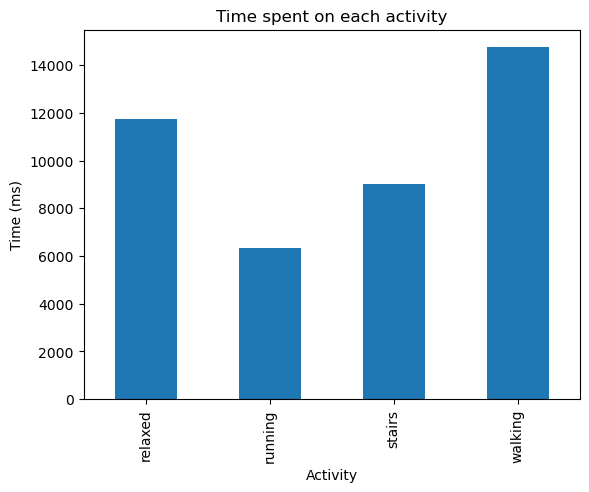

In [11]:
#plot the time spent on each activity
activity_time = final_data.groupby('Activity').size()
activity_time.plot(kind='bar', title='Time spent on each activity')
plt.ylabel('Time (ms)')
plt.xlabel('Activity')
plt.show()

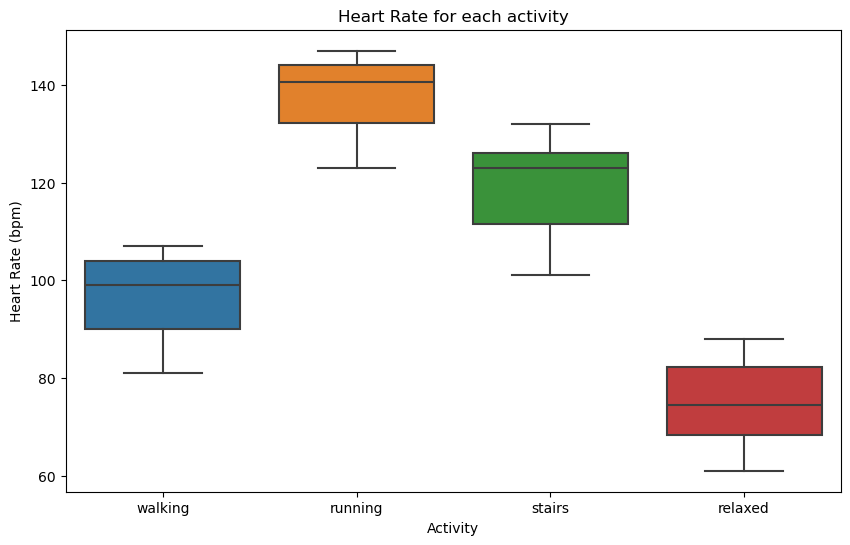

In [12]:
#plot the heart rate for each activity
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_data, x='Activity', y='Heart Rate (bpm)')
plt.title('Heart Rate for each activity')
plt.ylabel('Heart Rate (bpm)')
plt.xlabel('Activity')
plt.show()